In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
import datetime

## Data  pre-processing and visualization

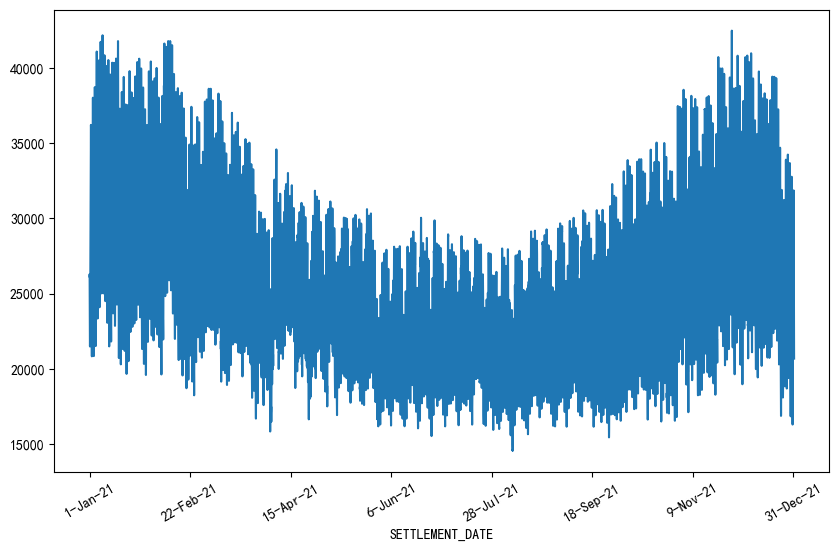

In [7]:
df=pd.read_csv(r'C:\Users\qaz25\Desktop\demanddata_2021.csv',index_col=0)
df['ENGLAND_WALES_DEMAND'].plot(figsize=(10,6))
plt.xticks(rotation=30)
plt.show()

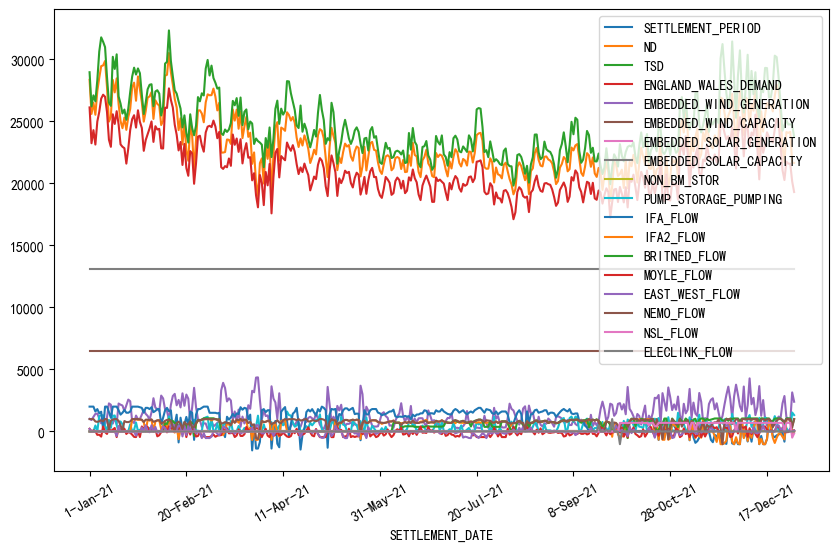

In [14]:
df.loc[df['SETTLEMENT_PERIOD']==1].plot(figsize=(10,6))
plt.xticks(rotation=30)
plt.show()

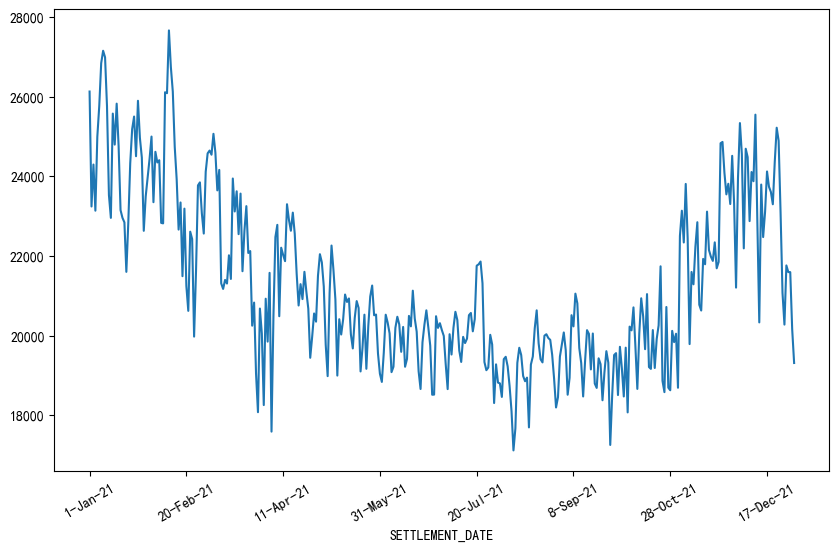

In [13]:
df.loc[df['SETTLEMENT_PERIOD']==1]['ENGLAND_WALES_DEMAND'].plot(figsize=(10,6))
plt.xticks(rotation=30)
plt.show()

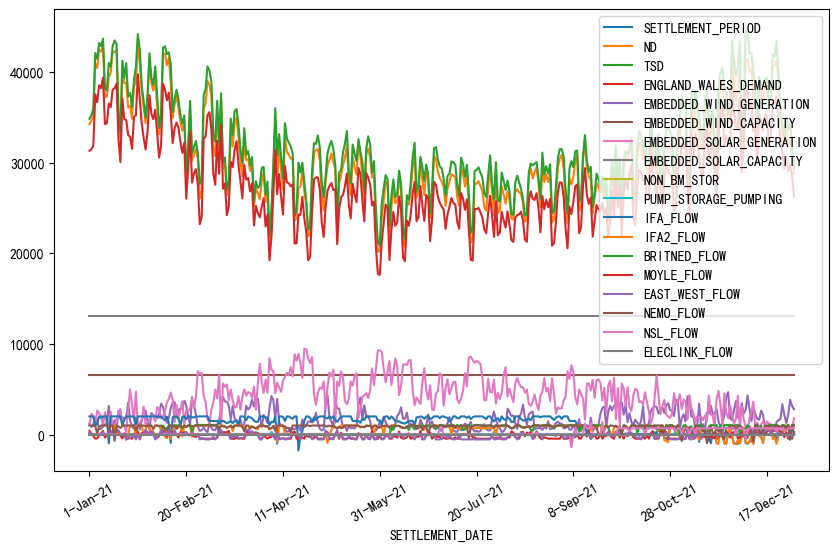

In [12]:
df.loc[df['SETTLEMENT_PERIOD']==25].plot(figsize=(10,6))
plt.xticks(rotation=30)
plt.show()

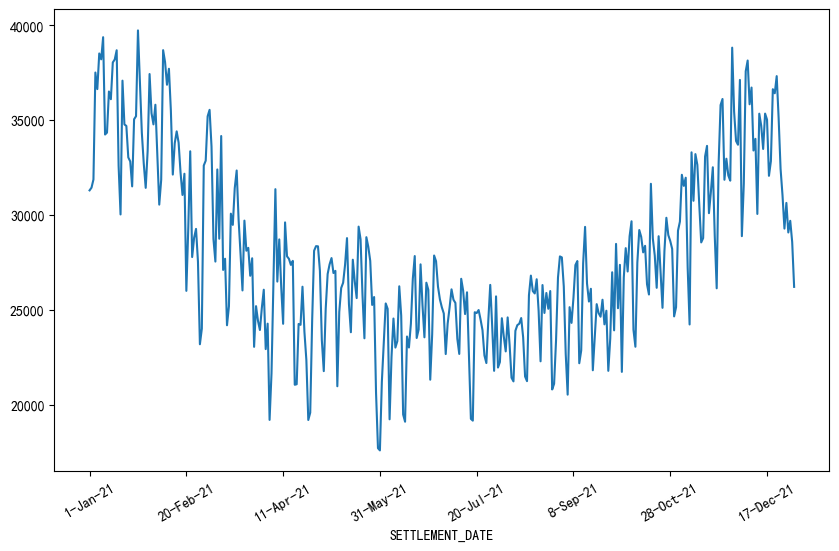

In [15]:
df.loc[df['SETTLEMENT_PERIOD']==25]['ENGLAND_WALES_DEMAND'].plot(figsize=(10,6))
plt.xticks(rotation=30)
plt.show()

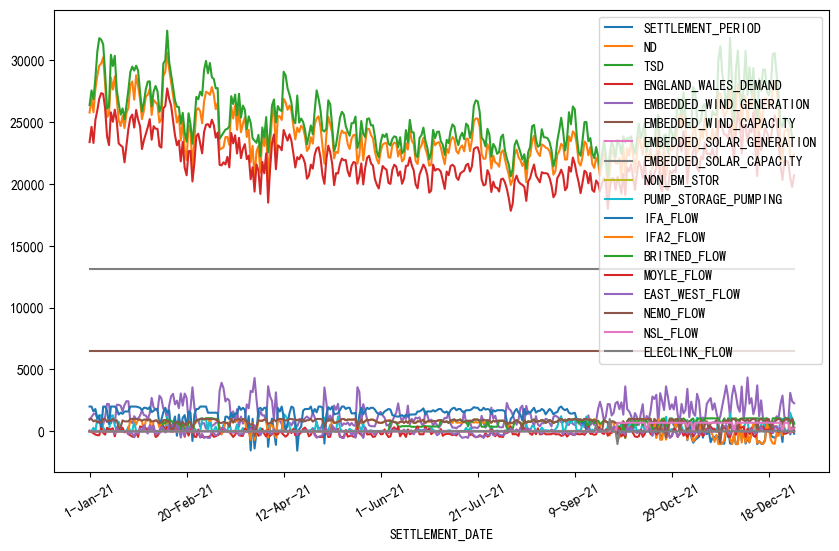

In [11]:
df.loc[df['SETTLEMENT_PERIOD']==48].plot(figsize=(10,6))
plt.xticks(rotation=30)
plt.show()

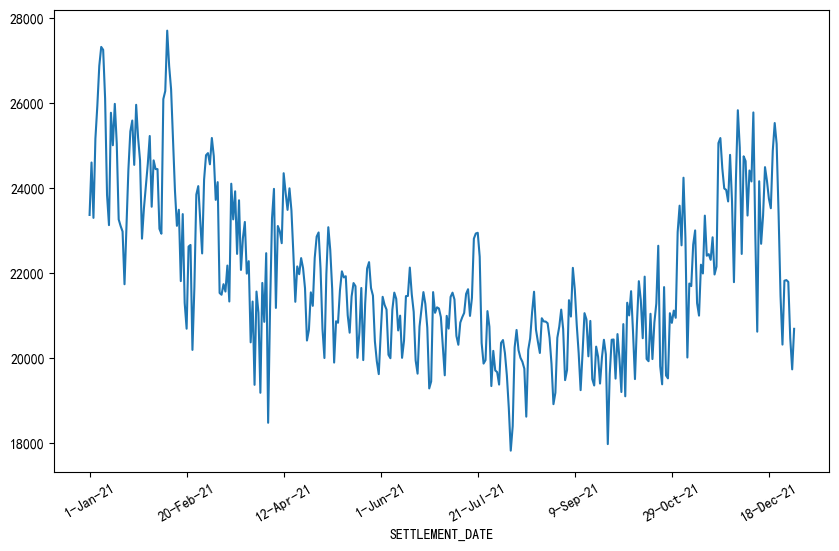

In [16]:
df.loc[df['SETTLEMENT_PERIOD']==48]['ENGLAND_WALES_DEMAND'].plot(figsize=(10,6))
plt.xticks(rotation=30)
plt.show()

## Smoothness Tests and Differential Processing

In [41]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.loc[df['SETTLEMENT_PERIOD']==48]['ENGLAND_WALES_DEMAND'])
if result[1] > 0.05:
    print('p：%s，non-Smoothness' % (result[1]))
else:
    print('p：%s，Smoothness' % (result[1]))

p：0.2731228017407038，non-Smoothness


<AxesSubplot:xlabel='SETTLEMENT_DATE'>

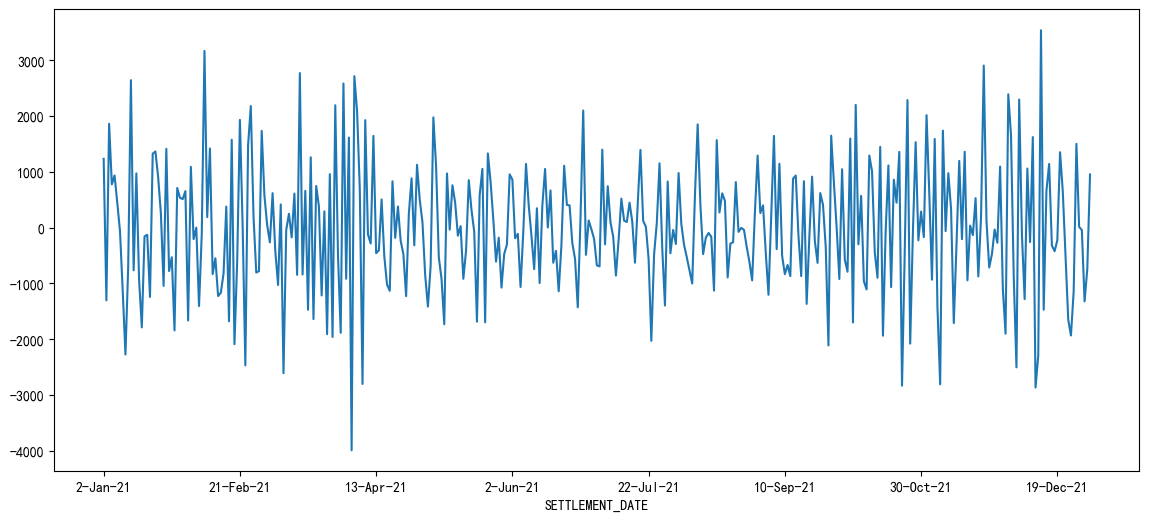

In [25]:
# first-order difference
bus_diff_1 = df.loc[df['SETTLEMENT_PERIOD']==48]['ENGLAND_WALES_DEMAND'].diff(1).dropna()
bus_diff_1.plot(figsize=(14,6))

In [40]:
result = adfuller(bus_diff_1)
if result[1] > 0.05:
    print('p：%s，non-Smoothness' % (result[1]))
else:
    print('p：%s，Smoothness' % (result[1]))

p：6.389458753342404e-11，Smoothness


<AxesSubplot:xlabel='SETTLEMENT_DATE'>

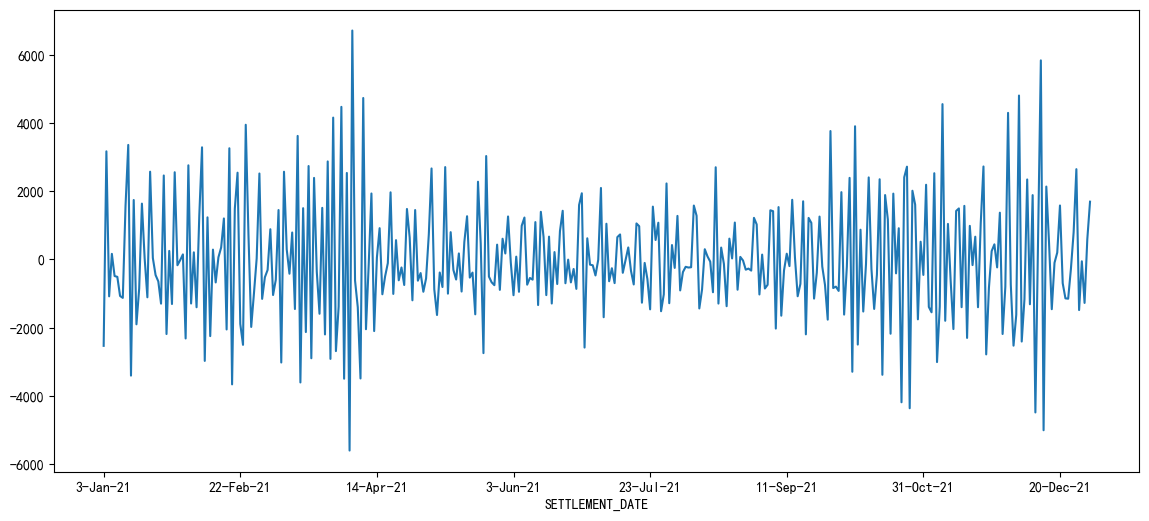

In [27]:
# second-order difference
bus_diff_2 = bus_diff_1.diff(1).dropna()
bus_diff_2.plot(figsize=(14,6))

In [39]:
# Unit root test for second order difference series
result = adfuller(bus_diff_2)
if result[1] > 0.05:
    print('p：%s，non-Smoothness' % (result[1]))
else:
    print('p：%s，Smoothness' % (result[1]))

p：1.9565855885110034e-16，Smoothness


## White noise test

In [38]:
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test
# LB
p = lb_test(bus_diff_2, lags=1).iloc[0, 1]
if p < 0.05:
    print(u'The second-order difference sequence is a non-white noise sequence with a p-value of:%s' % p)
else:
    print(u'The second-order difference sequence is a white noise sequence with a p-value of:%s' % p)

The second-order difference sequence is a non-white noise sequence with a p-value of:3.2505300833083264e-23


## Model Recognition


C:\Users\qaz25\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


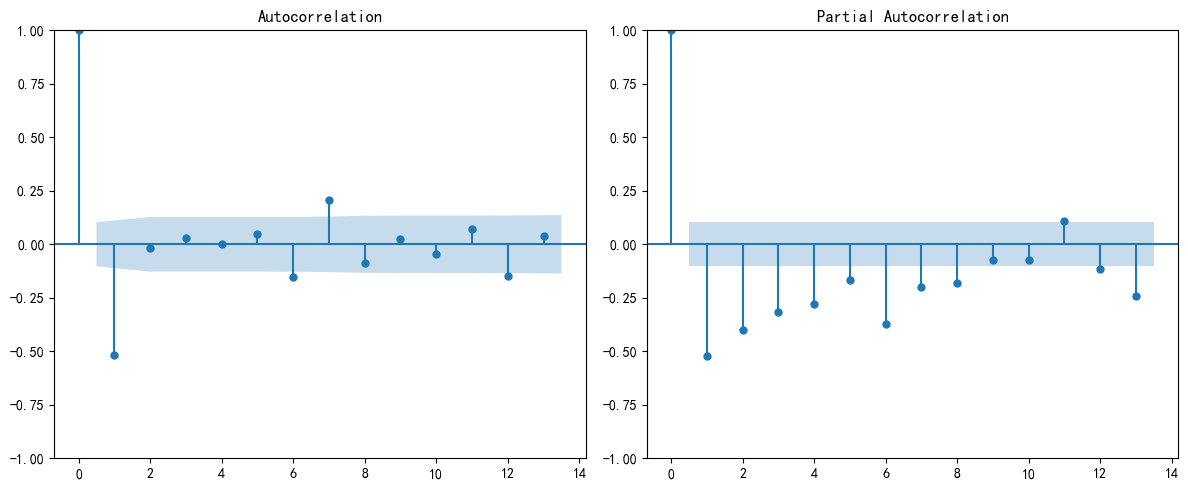

In [30]:
# ACF、PAC
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig=plt.figure(figsize=(12,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
plot_acf(bus_diff_2,ax=ax1,lags=13)
plot_pacf(bus_diff_2,ax=ax2,lags=13)
plt.tight_layout()
plt.show()

In [99]:
from statsmodels.tsa.api import ARIMA

aic_frame = pd.DataFrame(index=['AR{}'.format(i) for i in range(1,5)],
                           columns=['MA{}'.format(i) for i in range(1,5)])
for i in range(1,5):
    for j in range(1,5):
        arima = ARIMA(df.loc[df['SETTLEMENT_PERIOD']==48]['ENGLAND_WALES_DEMAND'].tolist(),order=(i, 2, j)).fit()
        aic_frame.loc['AR{}'.format(i), 'MA{}'.format(j)] = arima.aic

aic_frame = aic_frame[aic_frame.columns].astype(float)
aic_frame

D:\App\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\App\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\App\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\App\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\App\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

,MA1,MA2,MA3,MA4
AR1,168.181894,168.470975,170.013786,171.882841
AR2,170.181880,169.808266,169.913382,169.310512
AR3,172.096568,171.276035,170.304214,168.451470
AR4,167.139340,169.139326,165.896221,167.101810


Text(0.5, 1.0, 'AIC')

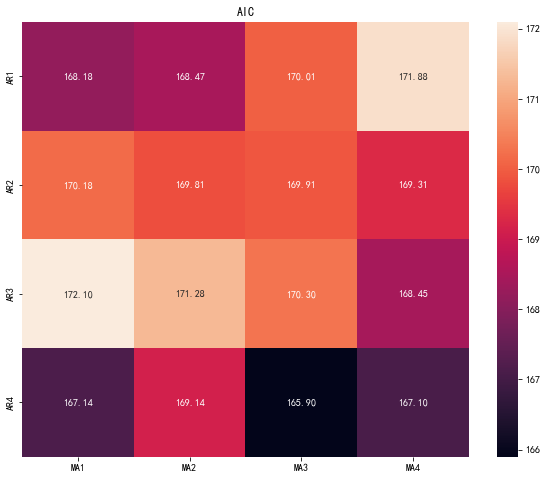

In [100]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(aic_frame,
                 mask=aic_frame.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f')
ax.set_title('AIC')

## Model

In [42]:
model1 = ARIMA(df.loc[df['SETTLEMENT_PERIOD']==48]['ENGLAND_WALES_DEMAND'], order=(4, 2, 3)).fit()
model2 = ARIMA(df.loc[df['SETTLEMENT_PERIOD']==48]['ENGLAND_WALES_DEMAND'], order=(3, 2, 1)).fit()
print(model1.summary(),model2.summary())

C:\Users\qaz25\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\qaz25\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\qaz25\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\qaz25\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\User

                                SARIMAX Results                                 
Dep. Variable:     ENGLAND_WALES_DEMAND   No. Observations:                  364
Model:                   ARIMA(4, 2, 3)   Log Likelihood               -3086.700
Date:                  Fri, 25 Aug 2023   AIC                           6189.401
Time:                          16:37:01   BIC                           6220.534
Sample:                               0   HQIC                          6201.777
                                  - 364                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8889      0.038    -50.320      0.000      -1.962      -1.815
ar.L2         -1.1905      0.073    -16.364      0.000      -1.333      -1.048
ar.L3         -0.3974      0.064    

## Validation

### Residual Normality Test

D:\App\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\App\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


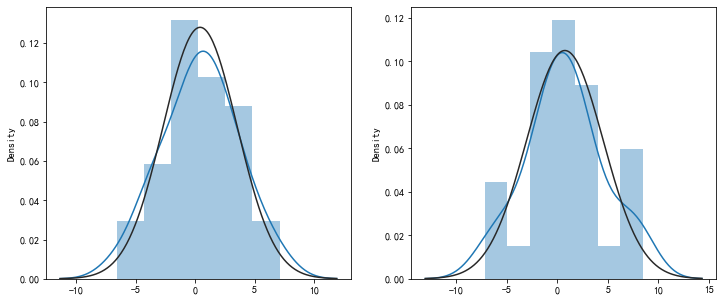

In [106]:
#Plotting Residual Histogram Density Plots
from scipy import stats
fig = plt.figure(figsize=(12,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.distplot(cancha1,kde=True,fit=stats.norm,ax=ax1)
sns.distplot(cancha2,kde=True,fit=stats.norm,ax=ax2)
plt.show()

NormaltestResult(statistic=0.023643552245004806, pvalue=0.9882478265272064)
NormaltestResult(statistic=0.0970477694508793, pvalue=0.9526345856185814)


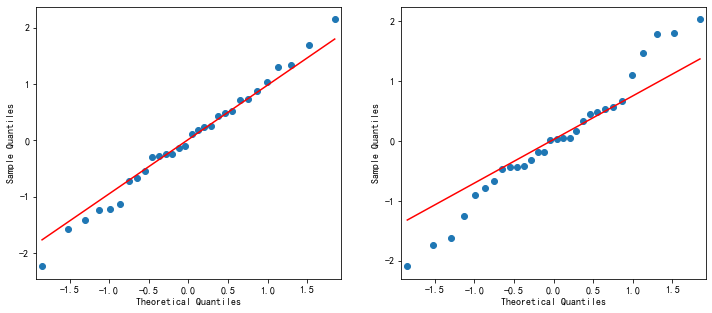

In [107]:
from statsmodels.graphics.api import qqplot
print(stats.normaltest(cancha1))
print(stats.normaltest(cancha2))
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig1 = qqplot(cancha1, line='q', ax=ax1, fit=True)
fig2 = qqplot(cancha2, line='q', ax=ax2, fit=True)
plt.show()